**Підготовка та аналіз даних. Лабораторна робота №2. ФБ-25 Кучеренко Владислав**

Наука про дані: підготовчий етап

Мета роботи: ознайомитися з основними кроками по роботі з даними – workflow від постановки задачі до написання пояснювальної записки, зрозуміти постановку задачі та природу даних, над якими виконується аналітичні операції

Основні поняття: сирі дані (raw data), підготовка даних (data preparation)

Для кожної із адміністративних одиниць України завантажити тестові структуровані файли, що містять значення VHI-індексу. Ця процедура має бути 
автоматизована, параметром процедури має бути індекс (номер) області. При зберіганні файлу до його імені потрібно додати дату та час завантаження;

In [ ]:
import urllib.request
import datetime
import os

def download():
    folder_path = 'C:\\Users\\vladi\\PycharmProjects\\DataAnalysis\\lab2\\csv_files'
    print('Downloading VHI files...')
    for i in range(1,28):
        url='https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?country=UKR&provinceID={}&year1=1981&year2=2020&type=Mean'.format(i)
        wp = urllib.request.urlopen(url)
        text = wp.read()
        now = datetime.datetime.now()
        date_and_time = now.strftime("%d_%m_%Y_%H-%M-%S")
        province_n = i
        file_path = os.path.join(folder_path, 'NOAA_ID{}_{}.csv'.format(province_n, date_and_time))
        with open(file_path, 'wb') as out:
            out.write(text)
    print('\nVHI files are downloaded!')
download()

Результат:

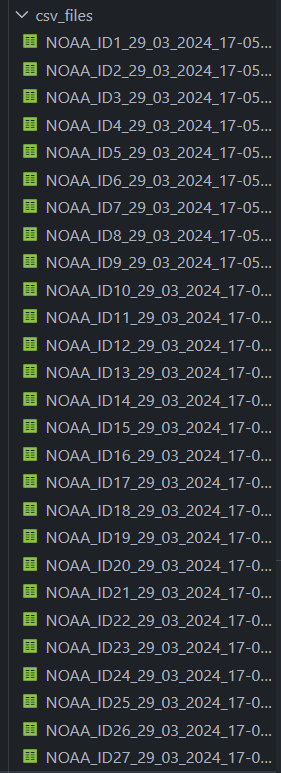

Зчитати завантажені текстові файли у фрейм (детальніше про роботу із фреймами буде розказано у подальших лабораторних роботах). Імена стовбців фрейму мають бути змістовними та легкими для сприйняття (не повинно бути спеціалізованих символів, пробілів тощо). Ця задача має бути реалізована у вигляді окремої процедури, яка на вхід приймає шлях до директорії, в якій зберігаються файли;

In [ ]:
import os
import pandas as pd

directory = 'C:\\Users\\vladi\\PycharmProjects\\DataAnalysis\\lab2\\csv_files'

def extract(directory):
    files = os.listdir(directory)
    headers = ['Year', 'Week', 'SMN', 'SMT', 'VCI', 'TCI', 'VHI', 'empty']
    main_df = pd.DataFrame()
    for i in range(len(files)):
        file_path = os.path.join(directory, files[i])
        df = pd.read_csv(file_path, header = 1, names = headers)
        df = df.drop(df.loc[df['VHI'] == -1].index)
        df['empty'] = df['empty'].apply(lambda x: 0 if pd.isnull(x) else x)

        df['area'] = i+1

        df['Year'] = df['Year'].str.replace('<tt><pre>', '')
        df = df.drop(df[df['Year'] == '</pre></tt>'].index)
        df['Year'] = df['Year'].astype(int)

        main_df = pd.concat([main_df, df])
    return main_df

Результат:


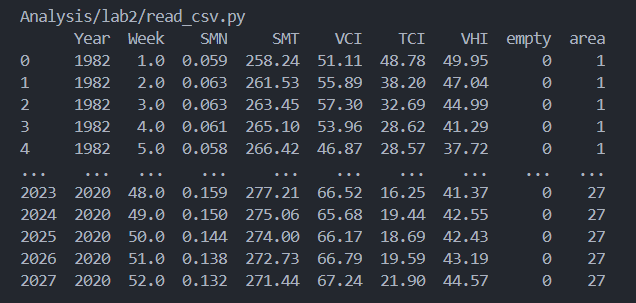

Реалізувати процедуру, яка змінить індекси областей, які використані на порталі NOAA на наступні:

In [ ]:
def change_index(df):
    new_index = {
        1: 22,
        2: 24,
        3: 23,
        4: 25,
        5: 3,
        6: 4,
        7: 8,
        8: 19,
        9: 20,
        10: 21,
        11: 9,
        12: 9,
        13: 10,
        14: 11,
        15: 12,
        16: 13,
        17: 14,
        18: 15,
        19: 16,
        20: 25,
        21: 17,
        22: 18,
        23: 6,
        24: 1,
        25: 2,
        26: 7,
        27: 5
    }
    df['area'] = df['area'].map(new_index)
    return df

Результат:

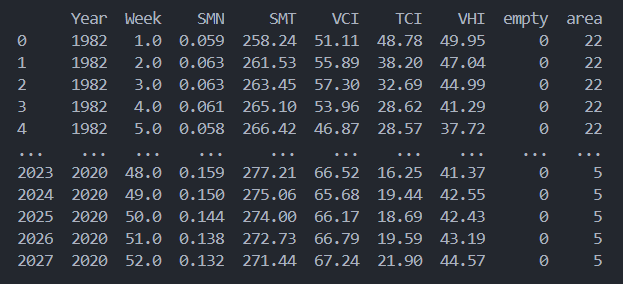

Реалізувати процедури для формування вибірок наступного виду (включаючи елементи аналізу):
o Ряд VHI для області за вказаний рік, пошук екстремумів (min та max);

In [ ]:
def extremum(df, index, year):
    min = df[(df['Year'] == year) & (df['area'] == index)]['VHI'].min()
    max = df[(df['Year'] == year) & (df['area'] == index)]['VHI'].max()
    print(f'Мінімальне значення VHI за {year} рік в регіоні {index}: {min}')
    print(f'Максимальне значення VHI за {year} рік в регіоні {index}: {max}')

Результат:

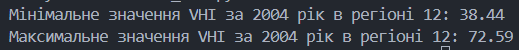

o Ряд VHI за вказаний діапазон років для вказаних областей;

In [ ]:
def vhi_by_years_and_areas(df, areas, start_year, end_year):
    selected_data = pd.DataFrame()
    for area in areas:
        area_data = df[(df['area'] == area) & (df['Year'] >= start_year) & (df['Year'] <= end_year)]
        selected_data = pd.concat([selected_data, area_data[['Year', 'VHI', 'area']]], axis=1)
    return selected_data

Результат:

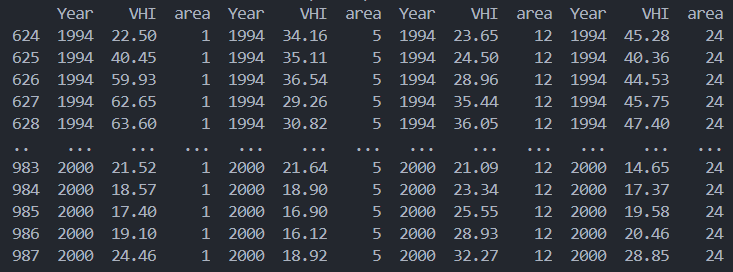

o Виявити роки, протягом яких екстремальні посухи торкнулися більше вказаного відсотка областей по Україні (20% областей - 5 областей з 25);

In [ ]:
def extreme_droughts(df):
    extreme_droughts = df[df['VHI'] <= 15]
    extreme_droughts_by_year = extreme_droughts.groupby('Year')['area'].nunique()
    percent = 20 
    extreme_drought_years = extreme_droughts_by_year[extreme_droughts_by_year > (len(df['area'].unique()) * percent / 100)]

    print("Екстремальні посухи торкнулися більше {}% областей в наступні роки:".format(percent))
    print(extreme_drought_years)

Результат:

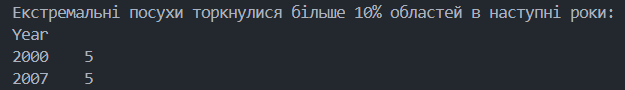

o Аналогічно для помірних посух

In [ ]:
def moderate_droughts(df):
    moderate_droughts = df[df['VHI'] <= 35]
    moderate_droughts_by_year = moderate_droughts.groupby('Year')['area'].nunique()
    percent = 20
    moderate_drought_years = moderate_droughts_by_year[moderate_droughts_by_year > (len(df['area'].unique()) * percent / 100)]
    
    print("Помірні посухи торкнулися більше {}% областей в наступні роки:".format(percent))
    print(moderate_drought_years)

Результат:

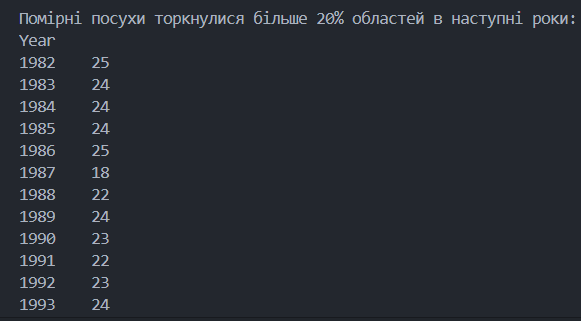

**Висновок**

Виконавши дану лабораторну роботу, я ознайомився з основними кроками по роботі з даними – workflow від постановки задачі до написання пояснювальної записки, зрозумів постановку задачі та природу даних, над якими виконуються аналітичні операції.